In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2

In [3]:
dataset_path = "D:\ML-FINALS\Primary Data"
image_dir = os.path.join(dataset_path, "images")


In [4]:
folder_path = r"D:\ML-FINALS\Primary Data\Primary Data"
files = os.listdir(folder_path)

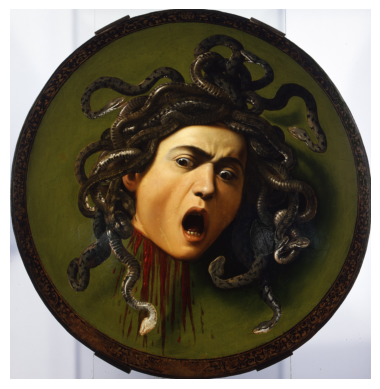

In [5]:
image_path = r"D:\ML-FINALS\Primary Data\Primary Data\Baroque\186670.jpg"
# Display the image using the displayImage function 


img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17490257652429044094
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10057940992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5596172723550067782
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [11]:
SIZE = 256
image_size = (SIZE, SIZE)

In [101]:
for art_style in os.listdir(folder_path):
    style_path = os.path.join(folder_path, art_style)
    if not os.path.isdir(style_path):
        continue

    print(f"Processing folder: {art_style}")

    for filename in os.listdir(style_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(style_path, filename)
            label_path = os.path.join(style_path, os.path.splitext(filename)[0] + ".txt")

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_path}")
                continue

            img = cv2.imread(image_path)
            if img is None:
                print(f"Warning: Could not load image {image_path}")
                continue

            img = cv2.resize(img, image_size)
            img = img / 255.0

            try:
                with open(label_path, "r") as f:
                    lines = f.readlines()

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        print(f"Invalid annotation in {label_path}: {line}")
                        continue

                    cls = int(parts[0])
                    bbox = list(map(float, parts[1:]))

                    X.append(img)
                    y_class.append(cls)
                    y_bbox.append(bbox)
                    class_ids.add(cls)
            except Exception as e:
                print(f"Error processing {label_path}: {str(e)}")

X = np.array(X, dtype=np.float32)

Processing folder: Academic_Art
Processing folder: Art_Nouveau
Processing folder: Baroque
Processing folder: Expressionism
Processing folder: Japanese_Art
Processing folder: Neoclassicism
Processing folder: Primitivism
Processing folder: Realism
Processing folder: Renaissance
Processing folder: Rococo
Processing folder: Romanticism
Processing folder: Symbolism
Processing folder: Western Medieval


In [102]:
# Map class IDs to indices
class_ids = sorted(list(class_ids))
class_to_idx = {cls: idx for idx, cls in enumerate(class_ids)}
num_classes = len(class_ids)

# Convert class labels to indices
if len(y_class) > 0:
    # One-hot encode class labels
    y_class = [class_to_idx[c] for c in y_class]
    y_class = to_categorical(y_class, num_classes=num_classes)
else:
    print("Warning: No class labels found in y_class")
    y_class = np.array([])

# Convert bounding box labels to numpy array
y_bbox = np.array(y_bbox, dtype=np.float32)

In [106]:
# First check if y_class is not empty
if len(y_class) > 0:
    # If y_class has data, proceed with counting
    unique, counts = np.unique(np.argmax(y_class, axis=1), return_counts=True)
    print("Distribution of classes:", dict(zip(unique, counts)))
else:
    print("y_class is empty. Please ensure data is loaded correctly.")

y_class is empty. Please ensure data is loaded correctly.


In [ ]:
input_layer = layers.Input(shape=(SIZE, SIZE, 3))

# Add more convolutional and pooling layers
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the output and add dense layers
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = layers.Dense(256, activation='relu')(x)

# Output: class probabilities
output = layers.Dense(num_classes, activation='softmax')(x)


In [16]:
model = models.Model(inputs=input_layer, outputs=[class_output, bbox_output])
model.compile(
    optimizer='adam',
    loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
    metrics={'class_output': 'accuracy'}
)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
21/21 [==============================] - 11s 212ms/step - loss: 1.2777 - class_output_loss: 1.2603 - bbox_output_loss: 0.0174 - class_output_accuracy: 0.3797 - val_loss: 1.0880 - val_class_output_loss: 1.0661 - val_bbox_output_loss: 0.0219 - val_class_output_accuracy: 0.4459
Epoch 2/10
21/21 [==============================] - 2s 92ms/step - loss: 0.9702 - class_output_loss: 0.9527 - bbox_output_loss: 0.0175 - class_output_accuracy: 0.5673 - val_loss: 0.6031 - val_class_output_loss: 0.5851 - val_bbox_output_loss: 0.0179 - val_class_output_accuracy: 0.8108
Epoch 3/10
21/21 [==============================] - 2s 90ms/step - loss: 0.5113 - class_output_loss: 0.4852 - bbox_output_loss: 0.0261 - class_output_accuracy: 0.8230 - val_loss: 0.3923 - val_class_output_loss: 0.3730 - val_bbox_output_loss: 0.0193 - val_class_output_accuracy: 0.8514
Epoch 4/10
21/21 [==============================] - 2s 90ms/step - loss: 0.4126 - class_output_loss: 0.3928 - bbox_output_loss: 0.0197 - class_

In [18]:
model.evaluate(X_test, {'class_output': y_cls_test, 'bbox_output': y_bbox_test})

6/6 [==============================] - 1s 179ms/step - loss: 0.3081 - class_output_loss: 0.2993 - bbox_output_loss: 0.0089 - class_output_accuracy: 0.9130


[0.30811363458633423,
 0.2992589771747589,
 0.008854634128510952,
 0.9130434989929199]

In [ ]:
# Get predictions from the model
y_pred = model.predict(X_test)
y_cls_pred = y_pred[0]  # class predictions

# Convert predictions and true labels from one-hot encoding to class indices
y_pred_classes = np.argmax(y_cls_pred, axis=1)
y_true_classes = np.argmax(y_cls_test, axis=1)

# Get unique class IDs to use as target names
target_names = [str(cls_id) for cls_id in class_ids]

# Create classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.86      0.88        56
     Class 1       0.98      0.93      0.95        44
     Class 2       0.85      0.89      0.87        45
     Class 3       0.93      1.00      0.96        39

    accuracy                           0.91       184
   macro avg       0.92      0.92      0.92       184
weighted avg       0.91      0.91      0.91       184



In [83]:
model.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmp0jltjwrc\assets


INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmp0jltjwrc\assets
